# Binance Perpetual Futures — Funding, Basis, and Carry (Hands‑On)

This notebook mirrors the options tutorial style, but for **USDⓈ-M perpetual futures**:
- Pulls **live** Binance premium index & funding data (or uses bundled **sample**).
- Computes **basis** and **annualized premium**.
- Plots **funding rate** history and **cumulative PnL** for long vs short.
- Demonstrates a simple **cash‑and‑carry** (spot vs perp) simulation.
- Shows classic **cost‑of‑carry** fair forward pricing for expiring futures.

## 0) Environment

Install requirements if needed:
```bash
pip install -r requirements.txt
```

In [1]:

# 1) Imports & Config
import os, sys, json, math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("src")
from futures_math import (year_fraction, cost_of_carry_fair_price, basis, annualize_basis,
                          funding_cashflows, cash_and_carry_pnl, predicted_funding_from_premium)
from binance_futures_adapter import exchange_info, premium_index, funding_rate_history

# Toggle live calls
USE_LIVE = True       # set True to hit Binance endpoints
SYMBOL = "BTCUSDT"
SAMPLE_PREMIUM = "data/sample_premium_index.json"
SAMPLE_FUNDING = "data/sample_funding_rates.json"


In [2]:

# 2) Load data (Live -> fallback)
def load_data():
    if USE_LIVE:
        try:
            prem = premium_index(SYMBOL)     # dict
            fund = funding_rate_history(SYMBOL, limit=200)  # list of dicts
            return prem, fund
        except Exception as e:
            print("Live fetch failed; falling back to sample. Reason:", repr(e))
    with open(SAMPLE_PREMIUM, "r") as f:
        prem = json.load(f)
    with open(SAMPLE_FUNDING, "r") as f:
        fund = json.load(f)
    return prem, fund

prem, fund = load_data()
prem


{'symbol': 'BTCUSDT',
 'markPrice': '114363.20000000',
 'indexPrice': '114425.21586957',
 'estimatedSettlePrice': '114205.99155990',
 'lastFundingRate': '0.00002094',
 'interestRate': '0.00010000',
 'nextFundingTime': 1755734400000,
 'time': 1755726956000}

In [3]:

# 3) Compute premium/basis and annualized premium
mark = float(prem["markPrice"])
index = float(prem["indexPrice"])
last_fr = float(prem.get("lastFundingRate", 0.0))
interest_per_interval = float(prem.get("interestRate", 0.0001))  # default ~0.01% per 8h
next_ts = int(prem["nextFundingTime"]) / 1000.0
now_ts = datetime.datetime.utcnow().timestamp()
T_years = year_fraction(now_ts, next_ts)  # until next funding

prem_frac = (mark - index) / index  # instantaneous premium vs index
ann_prem = annualize_basis(prem_frac, max(T_years, 1e-9))  # annualized
pred_fr = predicted_funding_from_premium(prem_frac, interest_per_interval)

summary = pd.DataFrame([{
    "symbol": prem["symbol"],
    "index": index,
    "mark": mark,
    "premium_fraction": prem_frac,
    "annualized_premium": ann_prem,
    "last_funding_rate": last_fr,
    "predicted_next_funding": pred_fr,
    "hours_to_next_funding": (next_ts - now_ts) / 3600.0
}])
summary


/var/folders/8t/py7199996lzcf46ws17_9lp80000gn/T/ipykernel_64106/3845379328.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now_ts = datetime.datetime.utcnow().timestamp()


,symbol,index,mark,premium_fraction,annualized_premium,last_funding_rate,predicted_next_funding,hours_to_next_funding
0,BTCUSDT,114425.21587,114363.2,-0.000542,-0.787374,0.000021,-0.000042,3.067396


## 1) Funding rate history and cumulative PnL

Positive **funding rate** means **longs pay** and **shorts receive** (per notional) at the funding timestamp.

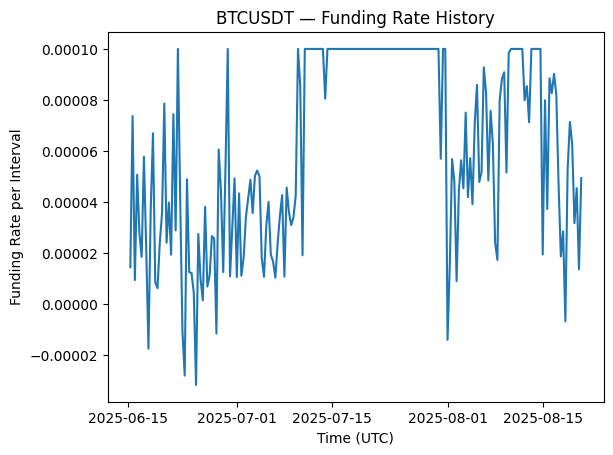

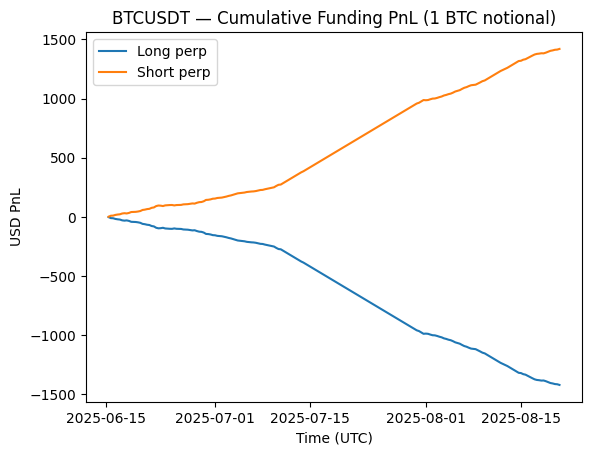

,symbol,fundingTime,fundingRate,markPrice,cumFunding_long,cumFunding_short
195,BTCUSDT,2025-08-19 08:00:00.001000+00:00,0.000063,114928.80000000,-1403.099161,1403.099161
196,BTCUSDT,2025-08-19 16:00:00+00:00,0.000032,113730.00000000,-1406.723007,1406.723007
197,BTCUSDT,2025-08-20 00:00:00+00:00,0.000045,112829.16656522,-1411.921345,1411.921345
198,BTCUSDT,2025-08-20 08:00:00+00:00,0.000014,113436.70000000,-1413.482105,1413.482105
199,BTCUSDT,2025-08-20 16:00:00+00:00,0.000049,113293.10000000,-1419.130134,1419.130134


In [4]:

df_f = pd.DataFrame(fund).copy()
df_f["fundingRate"] = pd.to_numeric(df_f["fundingRate"], errors="coerce")
df_f["fundingTime"] = pd.to_datetime(df_f["fundingTime"], unit="ms", utc=True)
df_f.sort_values("fundingTime", inplace=True)
df_f.reset_index(drop=True, inplace=True)

plt.figure()
plt.plot(df_f["fundingTime"], df_f["fundingRate"])
plt.title(f"{SYMBOL} — Funding Rate History")
plt.xlabel("Time (UTC)")
plt.ylabel("Funding Rate per Interval")
plt.show()

# cumulative funding PnL per 1 BTC notional at current index price
notional = 1.0 * index   # USD notional for 1 BTC
df_f["cumFunding_long"] = (df_f["fundingRate"]).cumsum() * (-notional)
df_f["cumFunding_short"] = (df_f["fundingRate"]).cumsum() * (+notional)

plt.figure()
plt.plot(df_f["fundingTime"], df_f["cumFunding_long"], label="Long perp")
plt.plot(df_f["fundingTime"], df_f["cumFunding_short"], label="Short perp")
plt.title(f"{SYMBOL} — Cumulative Funding PnL (1 BTC notional)")
plt.xlabel("Time (UTC)")
plt.ylabel("USD PnL")
plt.legend()
plt.show()

df_f.tail()


## 2) Simple cash‑and‑carry simulation

Enter **long spot / short perp** once; hold through all funding events. Ignore borrow rates and fees (configurable).  
Receive funding when funding is positive.

In [5]:

funding_rates = df_f["fundingRate"].values
pnl_cc = cash_and_carry_pnl(spot_qty=1.0, entry_price=index, funding_rates=funding_rates, fees_bps_per_leg=2.5)

pd.DataFrame([{"position": "long spot + short perp (1 BTC)", "entry_index": index, "pnl_usd": pnl_cc}])


,position,entry_index,pnl_usd
0,long spot + short perp (1 BTC),114425.21587,1361.917526


## 3) Cost‑of‑carry forward price (expiring futures)

For a dated future with time to expiry \(T\), **fair** forward price (under ideal assumptions) is

\[
F = S\,e^{(r - c)T}
\]

where \(r\) is the risk‑free rate, \(c\) is a convenience yield/carry. We can visualize the term structure implied by a choice of \(r\) and \(c\).

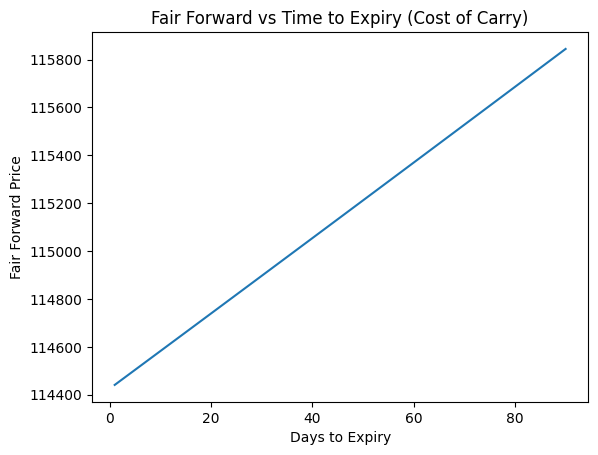

In [6]:

S = index
r = 0.05   # 5% annual
c = 0.00   # no carry
Ts = np.linspace(1/365, 90/365, 60)  # 1 day to 90 days
Fs = [cost_of_carry_fair_price(S, r, c, T) for T in Ts]

plt.figure()
plt.plot(Ts * 365, Fs)
plt.title("Fair Forward vs Time to Expiry (Cost of Carry)")
plt.xlabel("Days to Expiry")
plt.ylabel("Fair Forward Price")
plt.show()


---

### Notes
- **Premium index** ≈ (Perp Mark − Spot Index)/Spot Index.  
- **Funding** transfers every interval (commonly 8 hours). Positive → longs pay, shorts receive.  
- **Predicted funding** uses Binance’s documented formula with a cap/floor for the (Interest − Premium) adjustment.  
- **Cash-and-carry** ignores borrow/fees here; in production, include borrow APR, trading fees, and slippage.